<a href="https://colab.research.google.com/github/irkian/Brain_Tumor_Classifier/blob/main/BrainTumorClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dataDir ='/content/drive/My Drive/Colab Notebooks/BrainTumorClassification'


In [4]:
print(os.listdir(dataDir))
classes = os.listdir(dataDir+'/Training')
print(classes)

['Testing', 'Training', 'BrainTumorClassifier.ipynb']
['pituitary', 'notumor', 'meningioma', 'glioma']


In [5]:
meningioma_train = os.listdir(dataDir+'/Training/meningioma')
print('No. of training data for meningioma: ', len(meningioma_train))

No. of training data for meningioma:  1339


In [6]:
meningioma_test = os.listdir(dataDir+'/Testing/meningioma')
print('No. of training data for meningioma: ', len(meningioma_test))

No. of training data for meningioma:  306


In [7]:
meningioma_test[:5]

['Te-meTr_0007.jpg',
 'Te-meTr_0008.jpg',
 'Te-meTr_0003.jpg',
 'Te-meTr_0009.jpg',
 'Te-me_0012.jpg']

In [8]:
glioma_train = os.listdir(dataDir+'/Training/glioma')
print('No. of training data for glioma: ', len(glioma_train))

No. of training data for glioma:  1321


In [9]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [10]:
trainDir = dataDir+'/Training'
testDir = dataDir+'/Testing'

trainDir, testDir

('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training',
 '/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing')

In [11]:
def walkThroughDir(dirPath):
  for dirpath, dirnames, filenames in os.walk(dirPath):
    print(f'There are {len(dirnames)} directories and {len(filenames)} image in "{dirpath}"')

In [12]:
walkThroughDir(dataDir)

There are 2 directories and 1 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification"
There are 4 directories and 0 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing"
There are 0 directories and 300 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/glioma"
There are 0 directories and 405 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/notumor"
There are 0 directories and 306 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/meningioma"
There are 0 directories and 300 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/pituitary"
There are 4 directories and 0 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training"
There are 0 directories and 1457 image in "/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training/pituitary"
There are 0 directories and 1595 imag

In [13]:
import pathlib

imagePath = pathlib.PosixPath(dataDir)


In [14]:
imagePath

PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification')

Random image path: /content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training/glioma/Tr-gl_1191.jpg
Image class: glioma
Image height: 512
Image width: 512


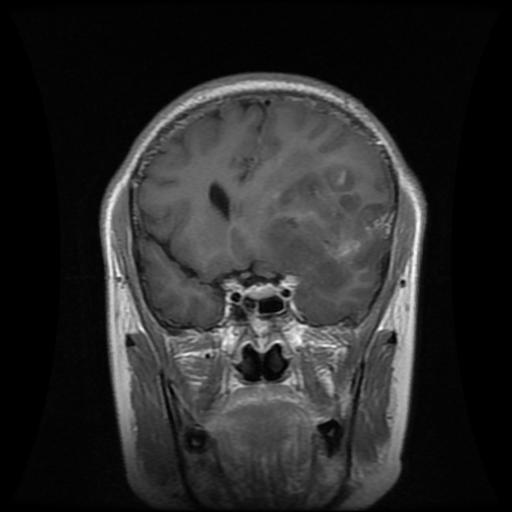

In [15]:
import random
from PIL import Image
# random.seed(42)

imagePathList= list(imagePath.glob("*/*/*.jpg"))


randomImagePath = random.choice(imagePathList)


imageClass = randomImagePath.parent.stem


img = Image.open(randomImagePath)

print(f'Random image path: {randomImagePath}')
print(f'Image class: {imageClass}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

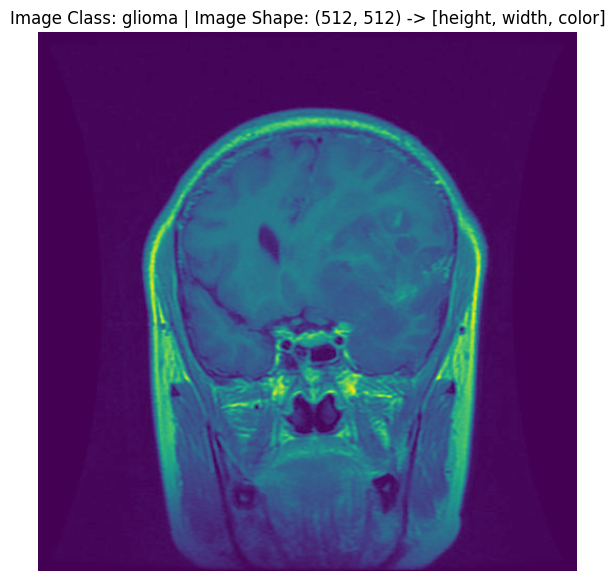

In [16]:
import numpy as np
import matplotlib.pyplot as plt

imageAsArray = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(imageAsArray)
plt.title(f'Image Class: {imageClass} | Image Shape: {imageAsArray.shape} -> [height, width, color]')
plt.axis(False);

In [17]:
imageAsArray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [18]:
#Transforming data with torchvision.transforms

dataTransform = transforms.Compose([
    #Resize our image
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [19]:
dataTransform(img)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0078, 0.0078,  ..., 0.0118, 0.0039, 0.0000],
         [0.0000, 0.0078, 0.0157,  ..., 0.0157, 0.0039, 0.0000],
         ...,
         [0.0000, 0.0039, 0.0157,  ..., 0.0118, 0.0000, 0.0000],
         [0.0000, 0.0039, 0.0118,  ..., 0.0118, 0.0039, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000]]])

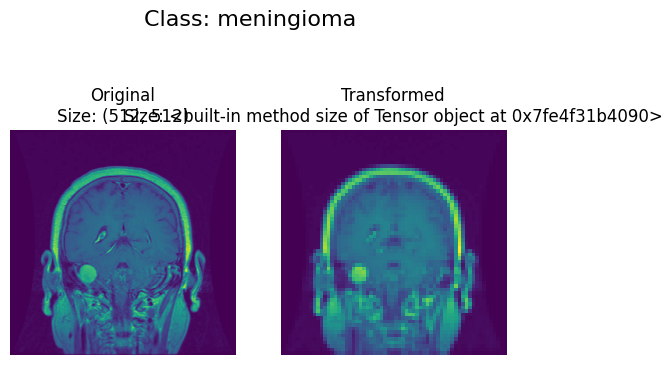

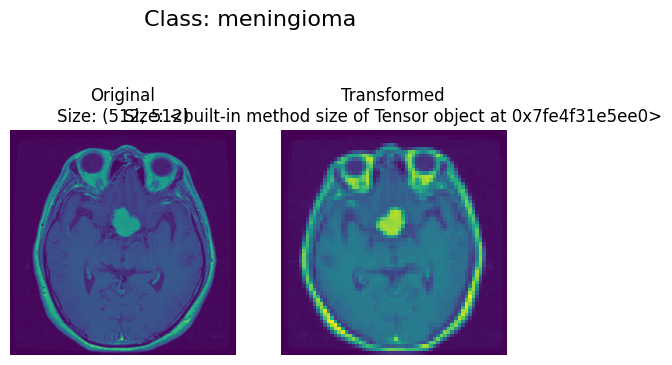

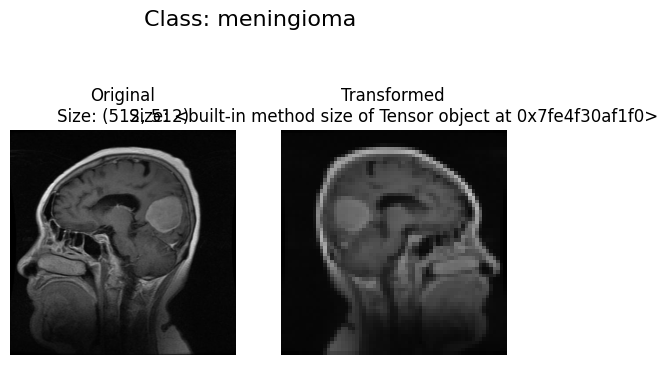

In [20]:
def plot_image(image_paths: list, transform, n=3, seed = None):
  if seed:
    random.seed(seed)
  randomImagePaths = random.sample(image_paths, k=n)
  for image_path in randomImagePaths:
    with Image.open(image_path) as f:
      fig , ax = plt.subplots(nrows=1,ncols =2 )
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nSize: {transformed_image.size}')
      ax[1].axis("off")

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize =16)


plot_image(image_paths=imagePathList,
           transform=dataTransform,
           n=3
           )


In [21]:
from torchvision import datasets

trainData = datasets.ImageFolder(root = trainDir,
                                 transform= dataTransform,
                                 target_transform=None)
testData = datasets.ImageFolder(root = testDir,
                                 transform= dataTransform
                               )
trainData, testData

(Dataset ImageFolder
     Number of datapoints: 5712
     Root location: /content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Training
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1311
     Root location: /content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [22]:
classNames = trainData.classes
classNames


['glioma', 'meningioma', 'notumor', 'pituitary']

In [23]:
classDict = trainData.class_to_idx
classDict

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [24]:
len(trainData), len(testData)

(5712, 1311)

In [25]:
img , label = trainData[0][0], trainData[0][1]

print(f'Image Tensor:\n {img}')
print(f'Image Shape:{img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatypes: {type(label)}')



Image Tensor:
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image Shape:torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatypes: <class 'int'>


Original Shape: torch.Size([3, 64, 64]) -> [color_channels, height, witdth]
Image permute: torch.Size([64, 64, 3]) -> [height, witdth,color_channels ]


Text(0.5, 1.0, 'glioma')

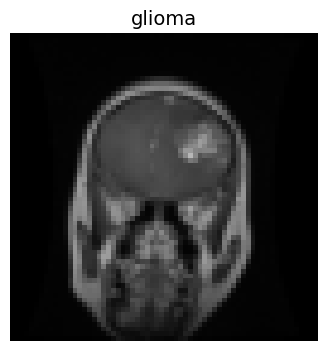

In [26]:
img_permute = img.permute(1,2,0)

print(f'Original Shape: {img.shape} -> [color_channels, height, witdth]')
print(f'Image permute: {img_permute.shape} -> [height, witdth,color_channels ]')

plt.figure(figsize=(8,4))
plt.imshow(img_permute)
plt.axis('off')
plt.title(classNames[label], fontsize = 14)

In [27]:
#Data Loader

#Data Loader turns dataset into python iterables and turn data into mini batches

# computationally efficient, some somputer hardware may not be able to look at 60,000 images in one hit.
# it gives our neural network more chance to update its gradients per epoch

In [28]:
from torch.utils.data.dataloader import DataLoader

BatchSize = 32

trainDataLoader = DataLoader( dataset= trainData,
                             batch_size= BatchSize,
                              shuffle= True)
testDataLoader = DataLoader(dataset=testData,
                            batch_size=BatchSize,
                            shuffle=False)

trainDataLoader, testDataLoader

(<torch.utils.data.dataloader.DataLoader at 0x7fe4f0cf78e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fe4f0cf7640>)

In [29]:
print(f'DataLoaders: {trainDataLoader, testDataLoader}')
print(f'Length of train data loader : {len(trainDataLoader)} batches of {BatchSize}')
print(f'Length of test data loader : {len(testDataLoader)} batches of {BatchSize}')

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fe4f0cf78e0>, <torch.utils.data.dataloader.DataLoader object at 0x7fe4f0cf7640>)
Length of train data loader : 179 batches of 32
Length of test data loader : 41 batches of 32


In [30]:
img, label = next(iter(trainDataLoader))
print(f'Image shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [31]:
#DataAugmentaiton

# Adding slightly modifies data theat we have existing data tha twe have
# To increase diversity of data so tha tmodel can view same data from different angle.

# Trivial augment

from torchvision import transforms

trainTransform = transforms.Compose([\
                                     transforms.Resize(size=(224,224)),
                                     transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                     transforms.ToTensor()
                                     ])

testTransform = transforms.Compose([\
                                     transforms.Resize(size=(224,224)),
                                     transforms.ToTensor()
                                     ])

In [32]:
imagePath

PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification')

In [33]:
image_path=list(imagePath.glob("*/*/*.jpg"))
image_path[:10]

[PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/glioma/Te-gl_0015.jpg'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/glioma/Te-gl_0023.jpg'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/glioma/Te-gl_0010.jpg'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/glioma/Te-glTr_0004.jpg'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/glioma/Te-glTr_0003.jpg'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/glioma/Te-gl_0025.jpg'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/glioma/Te-gl_0017.jpg'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/glioma/Te-glTr_0006.jpg'),
 PosixPath('/content/drive/My Drive/Colab Notebooks/BrainTumorClassification/Testing/glioma/Te-glTr_0001.jpg'),
 P

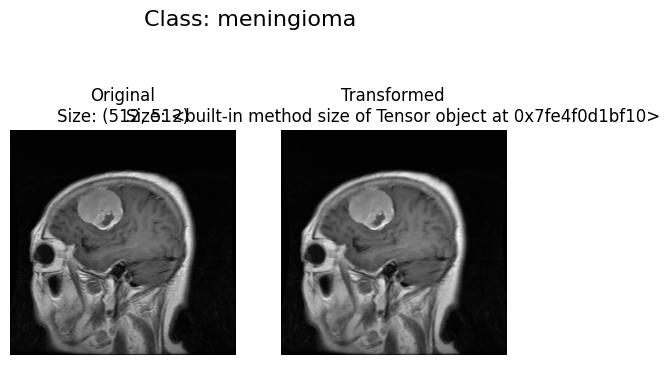

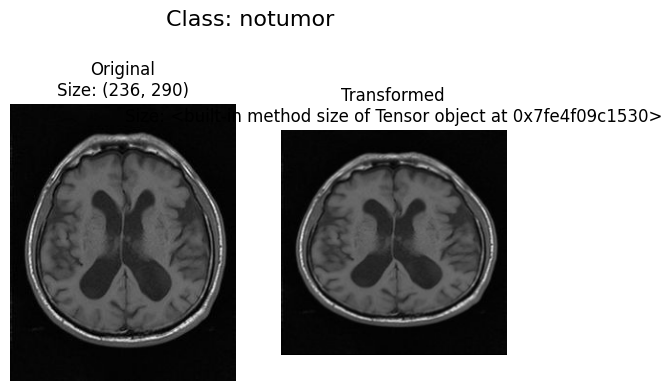

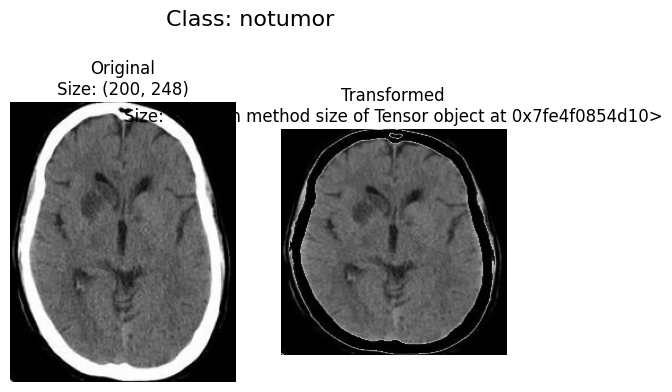

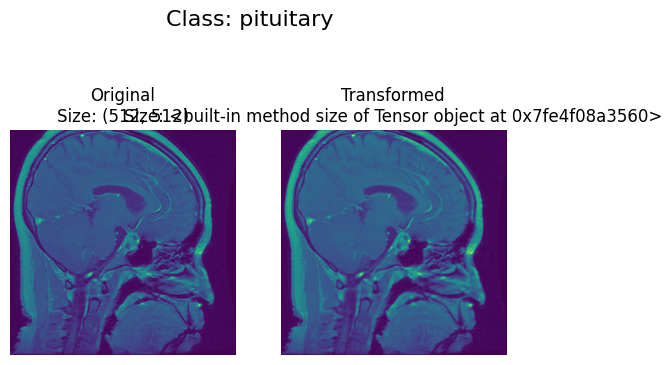

In [34]:
plot_image(
    image_paths=image_path,
    transform = trainTransform,
    n=4,
    seed = None
)

In [35]:
##Computer Vision Model

#TinyVVG architecture

#creating simple transfrom

simpleTransform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()

])

In [36]:
#Load and transform data
trainDataSimple = datasets.ImageFolder(root = trainDir,
                                       transform= simpleTransform)
testDataSimple = datasets.ImageFolder(root = testDir,
                                       transform= simpleTransform)

# turn dataset into dataloaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

trainDataLoaderSimple = DataLoader(dataset = trainDataSimple,
                                   batch_size=BATCH_SIZE,
                                   shuffle= True,
                                   num_workers=NUM_WORKERS
                                   )


trainDataLoaderSimple = DataLoader(dataset = testDataSimple,
                                   batch_size=BATCH_SIZE,
                                    shuffle= False,
                                   num_workers=NUM_WORKERS
                                  )

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [38]:
import torch
import torch.nn as nn



from torch.nn.modules.activation import ReLU
#TinyVGG model class

class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:

               super().__init__()
               self.conv_block1 = nn.Sequential(
                  nn.Conv2d(in_channels = input_shape,
                            out_channels = hidden_units,
                            kernel_size = 3,
                            stride = 1,
                            padding= 0),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = hidden_units,
                            out_channels = hidden_units,
                            kernel_size = 3,
                            stride = 1,
                            padding= 0),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2,
                               stride =2
                               )
               )

               self.conv_block2 = nn.Sequential(
                  nn.Conv2d(in_channels = hidden_units,
                            out_channels = hidden_units,
                            kernel_size = 3,
                            stride = 1,
                            padding= 0),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = hidden_units,
                            out_channels = hidden_units,
                            kernel_size = 3,
                            stride = 1,
                            padding= 0),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2,
                               stride =2
                               )
                              )
               self.conv_block3 = nn.Sequential(
                  nn.Conv2d(in_channels = hidden_units,
                            out_channels = hidden_units,
                            kernel_size = 3,
                            stride = 1,
                            padding= 0),
                  nn.ReLU(),
                  nn.Conv2d(in_channels = hidden_units,
                            out_channels = hidden_units,
                            kernel_size = 3,
                            stride = 1,
                            padding= 0),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=2,
                               stride =2
                               )
                              )






               self.classifier = nn.Sequential(
                  nn.Flatten(),
                  nn.Linear(in_features = hidden_units*4*4,
                            out_features = output_shape)
               )

  def forward(self,x):
    x = self.conv_block1(x)
    # print(x.shape)

    x= self.conv_block2(x)
    x= self.conv_block3(x)

    # print(x.shape)

    x = self.classifier(x)
    # print(x.shape)

    return x
    # return self.classifier(self.conv_block2(self.conv_block1(x)))


In [39]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=3,
                  output_shape=len(classNames)).to(device)
model_0

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=48, out_features=4, bias=True)
  )
)

In [40]:
#try forward pass to test model
image_batch, label_batch = next(iter(trainDataLoaderSimple))
image_batch.shape, label_batch.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [41]:
model_0(image_batch.to(device))

tensor([[ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0952, -0.1409,  0.1677],
        [ 0.1558,  0.0952, -0.1408,  0.1677],
        [ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0952, -0.1409,  0.1676],
        [ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0953, -0.1408,  0.1677],
        [ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0953, -0.1409,  0.1676],
        [ 0.1558,  0.0953, -0.1408,  0.1676],
        [ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0953, -0.1409,  0.1677],
        [ 0.1558,  0.0953, -0.1408,  0.1677],
        [ 0.1558,  0.0952, -0.1409,  0.1677],
        [ 0.1558,  0.0953, -0.1408,  0.1677],
        [ 0.1558,  0.0953, -0.1408

In [42]:
pip install torchinfo

In [43]:
from torchinfo import summary

summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 3, 30, 30]            --
│    └─Conv2d: 2-1                       [1, 3, 62, 62]            84
│    └─ReLU: 2-2                         [1, 3, 62, 62]            --
│    └─Conv2d: 2-3                       [1, 3, 60, 60]            84
│    └─ReLU: 2-4                         [1, 3, 60, 60]            --
│    └─MaxPool2d: 2-5                    [1, 3, 30, 30]            --
├─Sequential: 1-2                        [1, 3, 13, 13]            --
│    └─Conv2d: 2-6                       [1, 3, 28, 28]            84
│    └─ReLU: 2-7                         [1, 3, 28, 28]            --
│    └─Conv2d: 2-8                       [1, 3, 26, 26]            84
│    └─ReLU: 2-9                         [1, 3, 26, 26]            --
│    └─MaxPool2d: 2-10                   [1, 3, 13, 13]            --
├─Sequential: 1

In [44]:
#Creating train and test loop functions

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device= device):

  model.train()

  #setup train loss and train accuracy value

  train_loss, train_acc =0,0

  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc



In [45]:
#Create a test step

def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device=device):

  model.eval()

  #setup train loss and train accuracy value

  test_loss, test_acc =0,0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()


    test_pred_labels = test_pred_logits.argmax(dim=1)
    train_acc += (test_pred_labels==y).sum().item()/len(test_pred_labels)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [46]:
# creating a train function to combine train and test steps

from tqdm.auto import tqdm

#train function with model parameter, optimizer, data loaders, loss function

def train(model:torch.nn.Module,
          trainDataLoader: torch.utils.data.DataLoader,
          testDataLoader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          device = device):

  results={'train_loss': [],
           'train_acc': [],
           'test_loss':[],
           'test_acc': []}
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader=trainDataLoader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device = device)

    test_loss, test_acc = train_step(model = model,
                                       dataloader=trainDataLoader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device = device)
    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}| Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')


    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)


  return results

In [47]:
from torch.optim import optimizer
#Train and evaluate out model
# torch.manual_seed(40)
# torch.cuda.manual_seed(40)

NUM_EPOCHS = 15

model_0 = TinyVGG(input_shape =3,
                  hidden_units=3,
                  output_shape=len(trainData.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr = 0.0001)


from timeit import default_timer as timer
startTime = timer()

model_0_results = train(model = model_0,
                        trainDataLoader = trainDataLoaderSimple,
                        testDataLoader= testDataSimple,
                        optimizer=optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS
                        )

end_time= timer()
print(f'Total training time: {end_time-startTime:.3f} seconds')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.3909 | Train acc: 0.2287| Test loss: 1.3891 | Test acc: 0.2287
Epoch: 1 | Train loss: 1.3888 | Train acc: 0.2287| Test loss: 1.3885 | Test acc: 0.2287
Epoch: 2 | Train loss: 1.3882 | Train acc: 0.2287| Test loss: 1.3880 | Test acc: 0.2287
Epoch: 3 | Train loss: 1.3877 | Train acc: 0.2287| Test loss: 1.3875 | Test acc: 0.2287
Epoch: 4 | Train loss: 1.3873 | Train acc: 0.2287| Test loss: 1.3871 | Test acc: 0.2287
Epoch: 5 | Train loss: 1.3869 | Train acc: 0.0655| Test loss: 1.3867 | Test acc: 0.1410
Epoch: 6 | Train loss: 1.3865 | Train acc: 0.3087| Test loss: 1.3863 | Test acc: 0.3087
Epoch: 7 | Train loss: 1.3861 | Train acc: 0.3087| Test loss: 1.3860 | Test acc: 0.3087
Epoch: 8 | Train loss: 1.3858 | Train acc: 0.3087| Test loss: 1.3857 | Test acc: 0.3087
Epoch: 9 | Train loss: 1.3855 | Train acc: 0.3087| Test loss: 1.3854 | Test acc: 0.3087
Epoch: 10 | Train loss: 1.3852 | Train acc: 0.3087| Test loss: 1.3851 | Test acc: 0.3087
Epoch: 11 | Train loss: 1.3850 

In [48]:
model_0_results

{'train_loss': [1.3909337898580039,
  1.3887579731824922,
  1.3882159023750118,
  1.387726103387228,
  1.3872795541112015,
  1.3868705441312092,
  1.3864938689441215,
  1.3861455859207525,
  1.3858221216899593,
  1.385520824571935,
  1.385238964383195,
  1.3849744738602057,
  1.3847258963235995,
  1.3844904434390184,
  1.3842682198780338],
 'train_acc': [0.22865853658536586,
  0.22865853658536586,
  0.22865853658536586,
  0.22865853658536586,
  0.22865853658536586,
  0.06554878048780488,
  0.3086890243902439,
  0.3086890243902439,
  0.3086890243902439,
  0.3086890243902439,
  0.3086890243902439,
  0.3086890243902439,
  0.3086890243902439,
  0.3086890243902439,
  0.3086890243902439],
 'test_loss': [1.3890671933569558,
  1.3884795671556054,
  1.3879652226843484,
  1.3874978408580874,
  1.387070745956607,
  1.386678390386628,
  1.3863162790856711,
  1.3859809840597757,
  1.385668899954819,
  1.3853777152736013,
  1.3851046765722879,
  1.384849100578122,
  1.384606032836728,
  1.3843778517

In [49]:
#loss curve to track model progess over time

model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [50]:
def plot_loss_curve(results: dict[str, list[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()


  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

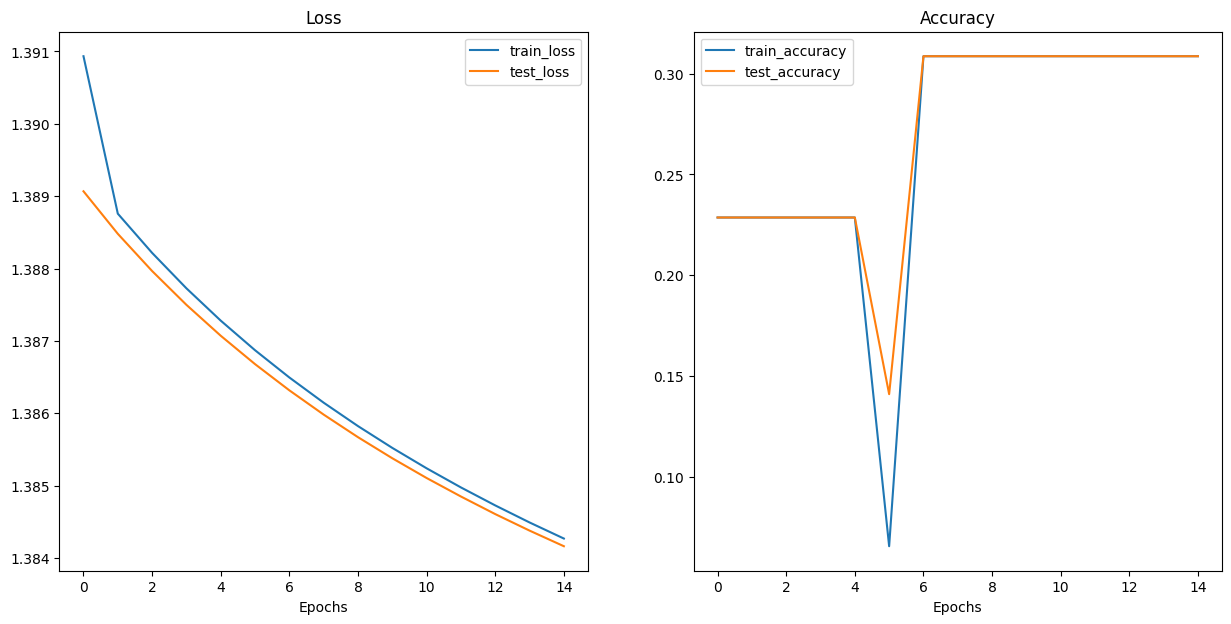

In [51]:
plot_loss_curve(model_0_results)